In [32]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import copy
import warnings
warnings.filterwarnings('ignore')
import cv2
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input,Lambda
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16,preprocess_input
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

/kaggle/input/louisianaflood2016classified/valid/0/2009.png
/kaggle/input/louisianaflood2016classified/valid/0/11003.png
/kaggle/input/louisianaflood2016classified/valid/0/5006_0.png
/kaggle/input/louisianaflood2016classified/valid/0/16000.png
/kaggle/input/louisianaflood2016classified/valid/0/13008.png
/kaggle/input/louisianaflood2016classified/valid/0/2009_0.png
/kaggle/input/louisianaflood2016classified/valid/0/12006.png
/kaggle/input/louisianaflood2016classified/valid/0/12008_0.png
/kaggle/input/louisianaflood2016classified/valid/0/4008.png
/kaggle/input/louisianaflood2016classified/valid/0/15007.png
/kaggle/input/louisianaflood2016classified/valid/0/13010_0.png
/kaggle/input/louisianaflood2016classified/valid/0/11010.png
/kaggle/input/louisianaflood2016classified/valid/0/1005.png
/kaggle/input/louisianaflood2016classified/valid/0/6007.png
/kaggle/input/louisianaflood2016classified/valid/0/12003.png
/kaggle/input/louisianaflood2016classified/valid/0/5006.png
/kaggle/input/louisiana

In [33]:
W = 224 # The default size for vgg16 is 224 but resize to .5 to save memory size
H = 224 # The default size for vgg16 is 224 but resize to .5 to save memory size
label_to_class = {
    '0': 0,
    '1': 1,

}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='../input/louisianaflood2016classified/train', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
        
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            img = load_img('/'.join([dir_name, label_name, img_name]), target_size=(W, H))
            img = img_to_array(img)
            
            Images.append(img)
            Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [34]:

Images, Classes = get_images()

Images.shape, Classes.shape

((270, 224, 224, 3), (270,))

0 184 0.6814814814814815


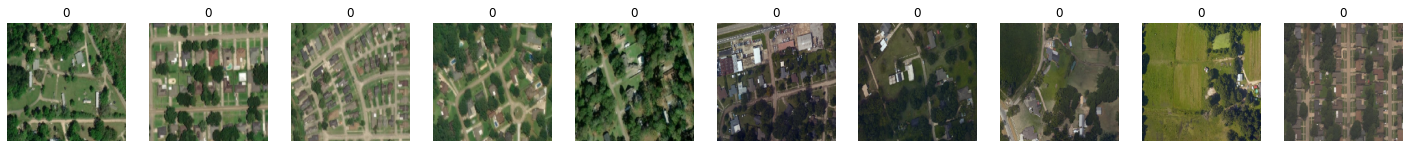

1 86 0.31851851851851853


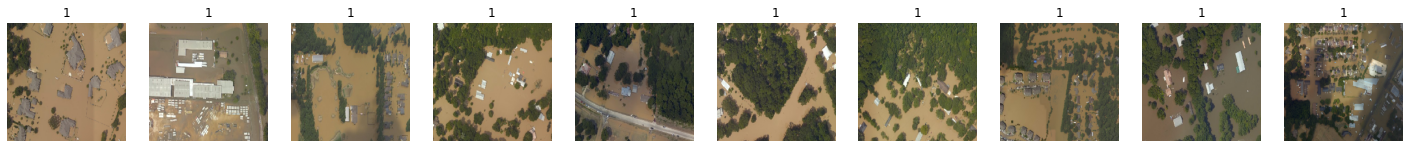

In [35]:
n_total_images = Images.shape[0]

for target_cls in [0, 1]:
    
    indices = np.where(Classes == target_cls)[0] # get target class indices on Images / Classes
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label, n_target_cls, n_target_cls/n_total_images)

    n_cols = 10 # # of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

In [36]:

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=False)

x_train = Images[indices_train] 
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((216, 224, 224, 3), (216,), (54, 224, 224, 3), (54,))

In [37]:

y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape


((216, 2), (54, 2))

In [38]:
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    zoom_range=0.1,                          # Randomly zoom image
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [39]:
def build_model():
    """build model function"""
    
    # vgg16
    input_tensor = Input(shape=(W, H, 3)) # To change input shape
    vgg16 = VGG16(
        include_top=False,                # To change output shape
        weights='imagenet',               # Use pre-trained model
        input_tensor=input_tensor,        # Change input shape for this task
    )
    # fc layer
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D())               # Add GAP for cam
    top_model.add(Dense(n_classes, activation='softmax')) # Change output shape for this task
     
    # model
    model = Model(vgg16.input, top_model(vgg16.output))
    
    # frozen weights
    for layer in model.layers[:-1]:
        layer.trainable = False or isinstance(layer, BatchNormalization) # If Batch Normalization layer, it should be trainable
        
    # compile
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [40]:

model = build_model()


In [41]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [42]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [43]:
history = model.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=datagen_test.flow(x_test, y_test, batch_size=32),
    callbacks=[early],
)

Epoch 1/50
7/7 [==============================] - 3s 331ms/step - batch: 3.0000 - size: 30.8571 - loss: 1.1627 - accuracy: 0.5880 - val_loss: 0.7041 - val_accuracy: 0.7222
Epoch 2/50
7/7 [==============================] - 2s 374ms/step - batch: 3.0000 - size: 30.8571 - loss: 0.7477 - accuracy: 0.7269 - val_loss: 0.4099 - val_accuracy: 0.7963
Epoch 3/50
7/7 [==============================] - 2s 342ms/step - batch: 3.0000 - size: 30.8571 - loss: 0.5271 - accuracy: 0.7593 - val_loss: 0.2912 - val_accuracy: 0.8519
Epoch 4/50
7/7 [==============================] - 2s 349ms/step - batch: 3.0000 - size: 30.8571 - loss: 0.3916 - accuracy: 0.8194 - val_loss: 0.2216 - val_accuracy: 0.8889
Epoch 5/50
7/7 [==============================] - 2s 362ms/step - batch: 3.0000 - size: 30.8571 - loss: 0.2983 - accuracy: 0.9028 - val_loss: 0.1917 - val_accuracy: 0.8889
Epoch 6/50
7/7 [==============================] - 3s 415ms/step - batch: 3.0000 - size: 30.8571 - loss: 0.2093 - accuracy: 0.9306 - val_loss

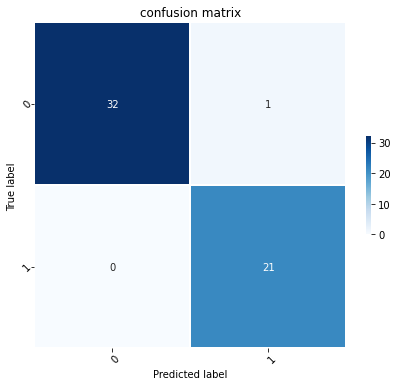

In [44]:
## plot confusion matrix

x = preprocess_input(copy.deepcopy(x_test))
y_preds = model.predict(x)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [45]:
def superimpose(img, cam):
    """superimpose original image and cam heatmap"""
    
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return img, heatmap, superimposed_img

In [46]:
def _plot(model, cam_func, img, cls_true):
    """plot original image, heatmap from cam and superimpose image"""
    
    # for cam
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title('heatmap')
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title('superimposed image')
    axs[2].axis('off')

    plt.suptitle('True label: ' + class_to_label[cls_true] + ' / Predicted label : ' + class_to_label[cls_pred])
    plt.tight_layout()
    plt.show()

In [47]:
def grad_cam(model, x, layer_name):
    """Grad-CAM function"""
    
    cls = np.argmax(model.predict(x))
    
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([x])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    cam /= np.max(cam)            # scale 0 to 1.0

    return cls, cam

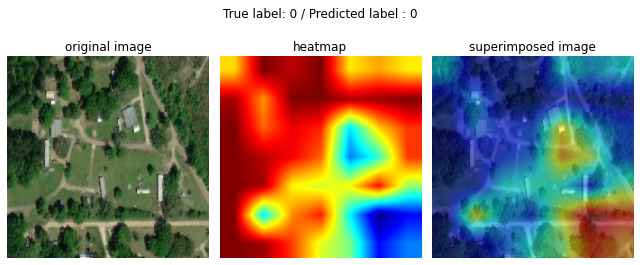

In [48]:


_plot(model=model, cam_func=grad_cam, img=Images[0], cls_true=Classes[0])


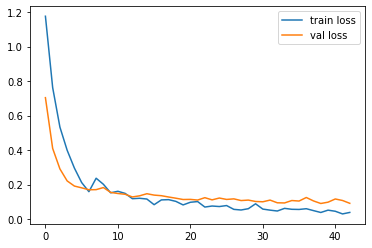

<Figure size 432x288 with 0 Axes>

In [49]:

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies


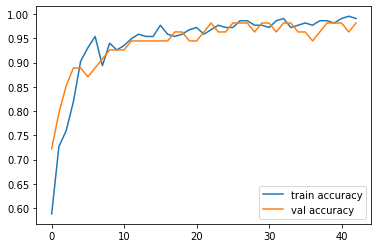

<Figure size 432x288 with 0 Axes>

In [50]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_accuracy')




In [51]:
from keras.models import load_model

model.save('vgg16flood.h5')